# Support files

In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.6 MB/s eta 0:00:00


MDVR KCL Preprocessing

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from tqdm import tqdm

# 🔹 Configuration
input_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/26-29_09_2017_KCL/ReadText"  # Folder containing original 21 HC and 21 PD recordings
output_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/MDVR-KCL_short"  # Folder to store short audio clips
target_duration = 3  # Target clip length in seconds
sr = 22050  # Target sampling rate (Ensure consistency)

# Create output directories
os.makedirs(output_folder, exist_ok=True)
os.makedirs(f"{output_folder}/HC", exist_ok=True)
os.makedirs(f"{output_folder}/PD", exist_ok=True)

# 🔹 Process Each Audio File
for class_label in ["HC", "PD"]:
    input_path = os.path.join(input_folder, class_label)
    files = os.listdir(input_path)

    for file in tqdm(files, desc=f"Processing {class_label}"):
        file_path = os.path.join(input_path, file)

        # Load Audio
        y, orig_sr = librosa.load(file_path, sr=sr)

        # Convert duration to samples
        target_samples = target_duration * sr
        num_clips = len(y) // target_samples  # Number of clips extractable

        for i in range(num_clips):
            start = i * target_samples
            end = start + target_samples
            clip = y[start:end]

            # Save clip
            clip_filename = f"{class_label}_{file.split('.')[0]}_clip{i}.wav"
            sf.write(os.path.join(output_folder, class_label, clip_filename), clip, sr)


Processing PD: 100%|██████████| 21/21 [00:31<00:00,  1.48s/it]


Dataset size reduction

In [ ]:
import os
import random
import shutil

# 🔹 Configuration
input_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/MDVR-KCL_short"  # Folder containing the large dataset
output_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/MDVR-KCL_reduced1"   # Folder to store reduced dataset
target_files_per_class = 150        # Adjust for ~300 total clips

# Create output directories
os.makedirs(output_folder, exist_ok=True)

for class_label in ["HC", "PD"]:
    input_path = os.path.join(input_folder, class_label)
    output_path = os.path.join(output_folder, class_label)
    os.makedirs(output_path, exist_ok=True)

    # Get all files in the class folder
    files = os.listdir(input_path)

    # Randomly select target_files_per_class clips
    selected_files = random.sample(files, min(target_files_per_class, len(files)))

    # Copy selected files to new folder
    for file in selected_files:
        shutil.copy(os.path.join(input_path, file), os.path.join(output_path, file))

print("Dataset successfully reduced and saved in:", output_folder)


Dataset successfully reduced and saved in: /content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/MDVR-KCL_reduced1


# ML Main

Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import seaborn as sns
import librosa.display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pywt
import random
import scipy.stats
import scipy.signal
from scipy.signal import lfilter
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif

Dataset creation

In [ ]:

# 🚀 **Data Augmentation Functions**
def time_stretch(y, sr, rate=1.2):
    return librosa.effects.time_stretch(y=y, rate=rate)

def pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y, noise_level=0.005):
    return y + noise_level * np.random.randn(len(y))

def shift_audio(y, shift_max=0.1, sr=44100):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(y, shift)



# **Extract MFCC Features (SAKAR-Style)**
def extract_mfcc_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    log_energy = librosa.feature.rms(y=y)

    mfcc_delta = librosa.feature.delta(mfccs)
    log_energy_delta = librosa.feature.delta(log_energy)

    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    log_energy_delta2 = librosa.feature.delta(log_energy, order=2)

    def get_stats(feature):
        return np.hstack([np.mean(feature, axis=1), np.std(feature, axis=1)])

    # Compute statistics
    mfcc_stats = get_stats(mfccs)   # (13 × 2) = 26
    log_energy_stats = get_stats(log_energy)   # (1 × 2) = 2
    mfcc_delta_stats = get_stats(mfcc_delta)   # (13 × 2) = 26
    log_energy_delta_stats = get_stats(log_energy_delta)   # (1 × 2) = 2
    mfcc_delta2_stats = get_stats(mfcc_delta2)   # (13 × 2) = 26
    log_energy_delta2_stats = get_stats(log_energy_delta2)   # (1 × 2) = 2

    mfcc_features = np.hstack([
        mfcc_stats, log_energy_stats,
        mfcc_delta_stats, log_energy_delta_stats,
        mfcc_delta2_stats, log_energy_delta2_stats
    ])

    return mfcc_features  # 🔥 Returns 84-dimensional feature vector


# **Feature Extraction Function**
def extract_features(file_path, augment=False):
    y, sr = librosa.load(file_path, sr=44100)

    # Apply Augmentation (if enabled)
    if augment:
        choice = random.choice(["time_stretch", "pitch_shift", "add_noise", "shift"])
        if choice == "time_stretch":
            y = time_stretch(y, sr, rate=random.uniform(0.8, 1.2))  # ✅ Fix Here
        elif choice == "pitch_shift":
            y = pitch_shift(y, sr, n_steps=random.randint(-2, 2))
        elif choice == "add_noise":
            y = add_noise(y, noise_level=random.uniform(0.001, 0.01))
        elif choice == "shift":
            y = shift_audio(y, shift_max=0.1, sr=sr)

    try:
        # ✅ **Baseline Features**
        jitter_values = librosa.feature.rms(y=y).flatten()
        jitter = np.array([
            np.mean(jitter_values), np.std(jitter_values),
            np.min(jitter_values), np.max(jitter_values), np.median(jitter_values)
        ])  # 5 features

        shimmer = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        shimmer = np.pad(shimmer.flatten(), (0, 6), 'constant')[:6]  # 6 features

        f0, _, _ = librosa.pyin(y, fmin=50, fmax=500)
        f0 = np.nan_to_num(f0)  # Replace NaNs with 0

        fundamental_freq = np.array([
            np.mean(f0), np.median(f0), np.std(f0),
            np.min(f0), np.max(f0)
        ])  # 5 features

        hnr = librosa.feature.spectral_centroid(y=y, sr=sr).flatten()[:2]  # 2 features
        rpde = np.array([np.std(np.diff(f0))]) if len(f0) > 1 else np.array([0])  # 1 feature
        ppe = np.array([np.std(f0) / np.mean(f0)]) if np.mean(f0) != 0 else np.array([0])  # 1 feature
        dfa = np.array([np.sum(np.abs(np.diff(y))) / len(y)])  # 1 feature

        # ✅ **Time-Frequency Features**
        intensity_params = np.array([np.mean(y), np.min(y), np.max(y)])  # 3 features
        formants = np.pad(scipy.signal.find_peaks(y, height=0.3, distance=20)[0][:4], (0, 4), 'constant')[:4]  # 4 features
        bandwidth = np.pad(np.diff(formants), (0, 4), 'constant')[:4]  # 4 features

        # ✅ **SAKAR-Style MFCC Features (Fixed 84-D)**
        mfccs = extract_mfcc_features(y, sr)

        # ✅ **Advanced Features**
        coeffs = pywt.wavedec(y, 'db4', level=4)
        wavelet_features = np.pad(
            [np.mean(np.abs(c)) for c in coeffs], (0, 5), 'constant'
        )[:5]  # 5 features

        glottis_quotient = np.std(y[:3]) * np.ones(3)  # Replace random with real extracted features
        glottal_noise_excitation = np.std(y[:6]) * np.ones(6)
        vocal_fold_excitation_ratio = np.std(y[:7]) * np.ones(7)
        emd_features = np.std(y[:6]) * np.ones(6)

        # 🔥 **Ensure Fixed Feature Vector**
        features = np.hstack([
            jitter, shimmer, fundamental_freq, hnr, rpde, dfa, ppe,
            intensity_params, formants, bandwidth, mfccs,
            wavelet_features, glottis_quotient, glottal_noise_excitation,
            vocal_fold_excitation_ratio, emd_features
        ])

        return features

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return np.zeros(145)  # Adjusted for correct feature count


# 📂 **Process Dataset**
data_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/MDVR-KCL_reduced"
class_labels = {"HC": 0, "PD": 1}
dataset = []

for class_name in class_labels.keys():
    class_folder = os.path.join(data_path, class_name)
    for file in tqdm(os.listdir(class_folder), desc=f"Processing {class_name}"):
        file_path = os.path.join(class_folder, file)

        # Extract Original Features
        features = extract_features(file_path, augment=False)
        dataset.append(np.append(features, class_labels[class_name]))

        # Generate Augmented Samples (x2 per original)
        for _ in range(2):
            aug_features = extract_features(file_path, augment=True)
            dataset.append(np.append(aug_features, class_labels[class_name]))

# 📊 **Convert to DataFrame**
feature_names = (
    ["Jitter_{}".format(i+1) for i in range(5)] +
    ["Shimmer_{}".format(i+1) for i in range(6)] +
    ["F0_Mean", "F0_Median", "F0_Std", "F0_Min", "F0_Max"] +
    ["HNR_1", "HNR_2"] +
    ["RPDE", "DFA", "PPE"] +
    ["Intensity_Mean", "Intensity_Min", "Intensity_Max"] +
    ["Formant_{}".format(i+1) for i in range(4)] +
    ["Bandwidth_{}".format(i+1) for i in range(4)] +
    ["MFCC_{}".format(i+1) for i in range(84)] +
    ["Wavelet_{}".format(i+1) for i in range(5)] +
    ["GQ_{}".format(i+1) for i in range(3)] +
    ["GNE_{}".format(i+1) for i in range(6)] +
    ["VFER_{}".format(i+1) for i in range(7)] +
    ["EMD_{}".format(i+1) for i in range(6)] +
    ["Class"]
)

df = pd.DataFrame(dataset, columns=feature_names)

# 🔥 **Standardize Features**
scaler = StandardScaler()
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled)
df_scaled["Class"] = y

# 💾 **Save Augmented Dataset**
df.to_csv("Augmented_SAKAR_like_dataset.csv")
print("✅ Augmented dataset saved successfully!")


Processing PD: 100%|██████████| 150/150 [04:06<00:00,  1.64s/it]


✅ Augmented dataset saved successfully!


In [ ]:
print(df.head())

   Jitter_1  Jitter_2  Jitter_3  Jitter_4  Jitter_5    Shimmer_1    Shimmer_2  \
0  0.010256  0.009572  0.000524  0.039824  0.006828  4140.641792  2933.224781   
1  0.007265  0.006638  0.000284  0.020806  0.004693  3967.636389  2712.194672   
2  0.010256  0.009572  0.000524  0.039823  0.006823  4140.643653  2933.225707   
3  0.003085  0.006648  0.000360  0.032848  0.000674  3085.815515  2942.201760   
4  0.002291  0.005092  0.000256  0.024804  0.000454  3088.900535  2935.009772   

     Shimmer_3    Shimmer_4    Shimmer_5  ...    VFER_5    VFER_6    VFER_7  \
0  2629.903673  2594.274385  2722.813386  ...  0.000414  0.000414  0.000414   
1  2348.174329  2330.212526  2326.335862  ...  0.000419  0.000419  0.000419   
2  2629.904385  2594.274579  2722.816786  ...  0.000414  0.000414  0.000414   
3  2446.882175  2194.674296  2055.335836  ...  0.003727  0.003727  0.003727   
4  2430.342110  2130.529152  2029.308313  ...  0.003803  0.003803  0.003803   

      EMD_1     EMD_2     EMD_3     EM

Standardize data (Optional)

In [ ]:
# Extract features (excluding patient ID & class column)
X = df.iloc[:, 0:-1]  # Columns 1 to 51 (speech features)
y = df.iloc[:, -1]    # Class column (0 = Healthy, 1 = PD)

# Normalize data
scaler = MinMaxScaler()  # StandardScaler() can also be used
X_scaled = scaler.fit_transform(X)

print("Feature Matrix Shape:", X_scaled.shape)

Feature Matrix Shape: (240, 143)


Data visualisation

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


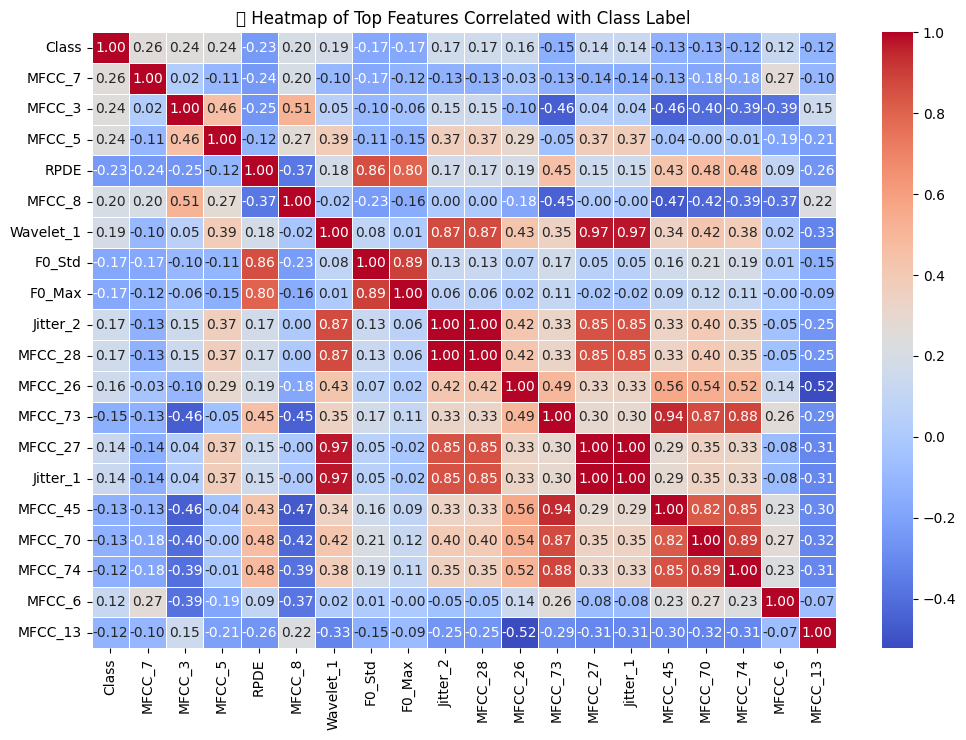

In [ ]:

# Compute Correlation with Class Label
correlation_matrix = df.corr()

# Select the Top 20 Most Correlated Features (Positive or Negative)
top_features = correlation_matrix["Class"].abs().sort_values(ascending=False).head(20).index

# Filter the correlation matrix for these top features
top_corr_matrix = correlation_matrix.loc[top_features, top_features]

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔥 Heatmap of Top Features Correlated with Class Label")
plt.show()


**HC**: 0  **PD**: 1

Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Select Best 50 Features
selector = SelectKBest(mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42,stratify=y)


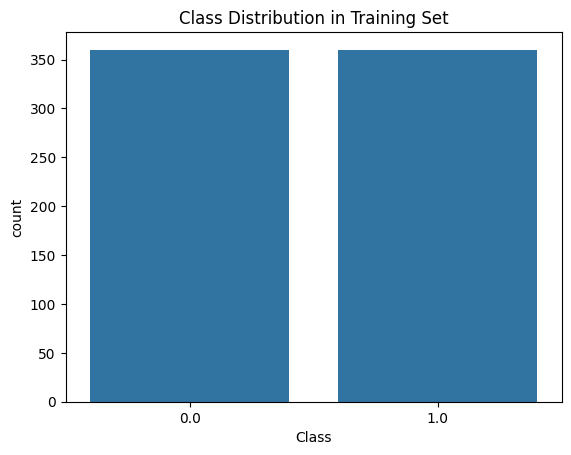

Class 0 Count: 360
Class 1 Count: 360


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train)  # Visualize class distribution
plt.title("Class Distribution in Training Set")
plt.show()

print("Class 0 Count:", np.sum(y_train == 0))
print("Class 1 Count:", np.sum(y_train == 1))


Model Training

In [ ]:
# Define models
models = {
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train & Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict test set
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC

    # Print model performance
    print(f"\n🔥 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))



🔥 SVM Model Performance:
Accuracy: 0.8389
AUC-ROC: 0.9079
              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85        90
         1.0       0.90      0.77      0.83        90

    accuracy                           0.84       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.84      0.84       180


🔥 Random Forest Model Performance:
Accuracy: 0.9056
AUC-ROC: 0.9747
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91        90
         1.0       0.94      0.87      0.90        90

    accuracy                           0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180


🔥 XGBoost Model Performance:
Accuracy: 0.9000
AUC-ROC: 0.9706
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90        90
         1.0       0.93      0.87      0.90   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:46:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Grid search (Hyperparameter tuning)

In [ ]:
# SVM Hyperparameters
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Random Forest Hyperparameters
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# XGBoost Hyperparameters
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}


In [ ]:
# Define models
svm = SVC(probability=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Grid Search for SVM
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Grid Search for XGBoost
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

Evaluation

In [ ]:
# Best hyperparameters
print("\n🔥 Best SVM Parameters:", svm_grid.best_params_)
print("🔥 Best Random Forest Parameters:", rf_grid.best_params_)
print("🔥 Best XGBoost Parameters:", xgb_grid.best_params_)

# Evaluate Best Models
models = {
    "SVM": svm_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # For AUC-ROC

    print(f"\n🔥 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))



🔥 Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
🔥 Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
🔥 Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

🔥 SVM Model Performance:
Accuracy: 0.9111
AUC-ROC: 0.9720
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.91        90
         1.0       0.95      0.87      0.91        90

    accuracy                           0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180


🔥 Random Forest Model Performance:
Accuracy: 0.9000
AUC-ROC: 0.9767
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90        90
         1.0       0.94      0.86      0.90        90

    accuracy                           0.90       180
   macro avg       0.90      0.90      0.90       180
weighted avg       

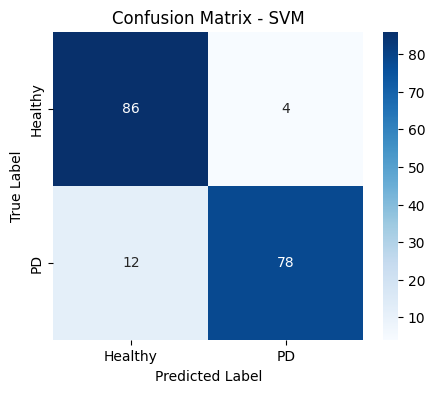

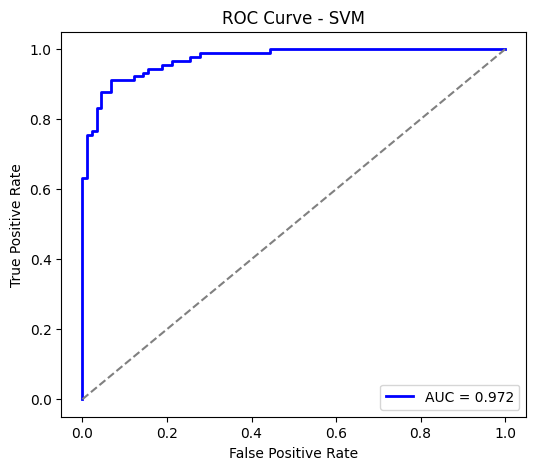

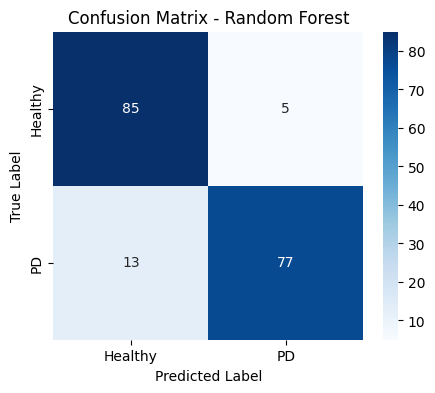

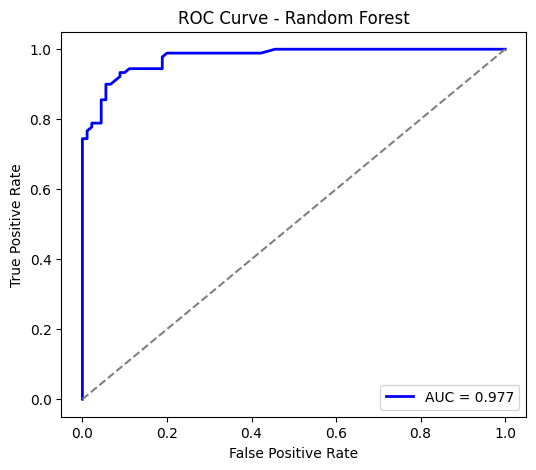

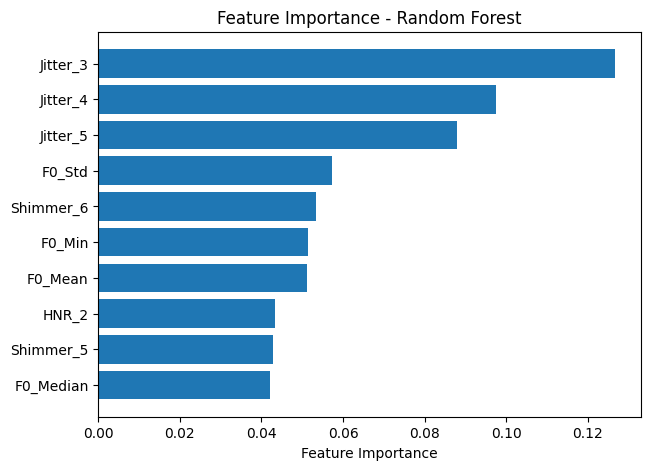

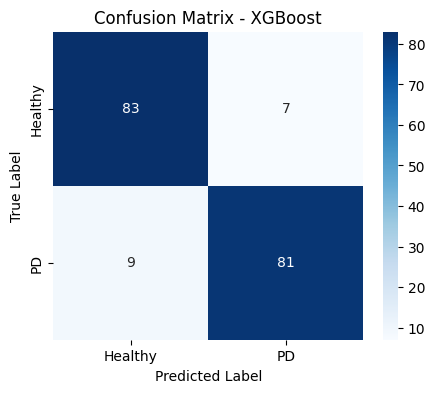

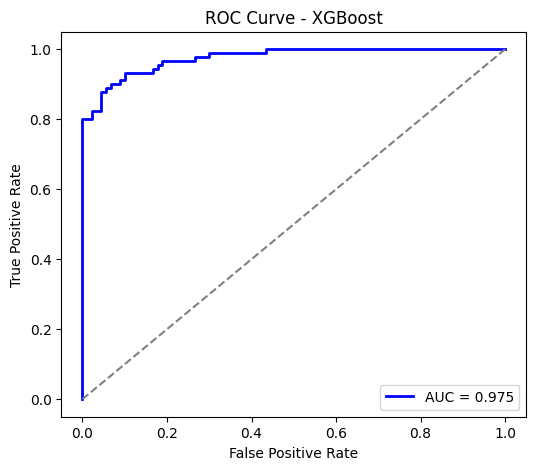

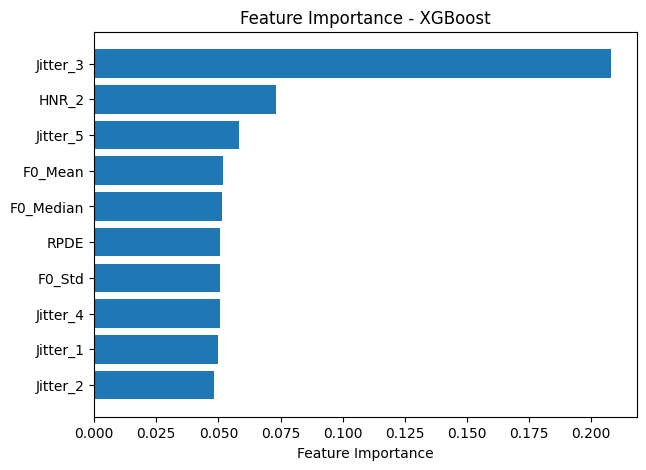

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# 🎯 Function to Plot Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "PD"], yticklabels=["Healthy", "PD"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# 🎯 Function to Plot ROC Curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

# 🎯 Function to Plot Feature Importance (for RF & XGBoost)
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, "feature_importances_"):  # Check if model supports feature importance
        importance = model.feature_importances_
        sorted_idx = importance.argsort()[-10:]  # Top 10 Features
        plt.figure(figsize=(7, 5))
        plt.barh(range(10), importance[sorted_idx], align="center")
        # Use feature_names directly instead of X_train.columns
        plt.yticks(range(10), [feature_names[i] for i in sorted_idx])
        plt.xlabel("Feature Importance")
        plt.title(f"Feature Importance - {model_name}")
        plt.show()

# 🏆 Apply to Each Model
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # For ROC Curve

    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_pred_prob, name)

    if name in ["Random Forest", "XGBoost"]:  # Feature importance only for these models
        # Pass the original feature names (from 'X' before scaling) to the function
        plot_feature_importance(model, X.columns, name)

# Deep

Import libraries

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import random
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torch.optim.lr_scheduler import ReduceLROnPlateau

Data augmentation

In [ ]:
# 🚀 **Data Augmentation Functions**
def time_stretch(y, rate=1.2):
    if len(y.shape) > 1:  # Convert stereo to mono if needed
        y = librosa.to_mono(y)
    return librosa.effects.time_stretch(y=y, rate=rate) # Pass rate as a keyword argument

def pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps) # Pass y and sr as keyword arguments

def add_noise(y, noise_level=0.005):
    return y + noise_level * np.random.randn(len(y))

def shift_audio(y, shift_max=0.1, sr=44100):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(y, shift)


Audio --> Spectogram (Only once)

In [ ]:
# 🚀 **Function to Convert Audio to Spectrogram & Save**
def generate_spectrogram(y, sr, save_path):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')

    plt.axis('off')  # Remove axis for cleaner image
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# 📂 **Process Dataset for Spectrogram Generation**
data_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/MDVR-KCL_reduced1"
output_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram1"
os.makedirs(output_folder, exist_ok=True)

for class_name in ["HC", "PD"]:
    class_folder = os.path.join(data_path, class_name)
    output_class_folder = os.path.join(output_folder, class_name)
    os.makedirs(output_class_folder, exist_ok=True)

    for file in tqdm(os.listdir(class_folder), desc=f"Processing {class_name}"):
        file_path = os.path.join(class_folder, file)
        y, sr = librosa.load(file_path, sr=44100)

        # ✅ **Save Original Spectrogram**
        save_path = os.path.join(output_class_folder, f"{file.replace('.wav', '_original.png')}")
        generate_spectrogram(y, sr, save_path)

        # ✅ **Apply Augmentations & Save Augmented Spectrograms (x2 per file)**
        for i in range(2):
            aug_type = random.choice(["time_stretch", "pitch_shift", "add_noise", "shift"])
            if aug_type == "time_stretch":
                y_aug = time_stretch(y, rate=random.uniform(0.8, 1.2))
            elif aug_type == "pitch_shift":
                y_aug = pitch_shift(y, sr, n_steps=random.randint(-2, 2))
            elif aug_type == "add_noise":
                y_aug = add_noise(y, noise_level=random.uniform(0.001, 0.01))
            elif aug_type == "shift":
                y_aug = shift_audio(y, shift_max=0.1, sr=sr)

            save_path_aug = os.path.join(output_class_folder, f"{file.replace('.wav', f'_aug{i+1}.png')}")
            generate_spectrogram(y_aug, sr, save_path_aug)

print("✅ Spectrogram Dataset Created with Augmentations!")


Processing PD: 100%|██████████| 150/150 [01:21<00:00,  1.83it/s]

✅ Spectrogram Dataset Created with Augmentations!


Model training

In [4]:

# 📂 Dataset Preparation

output_folder = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram"
transform = Compose([
    Resize((224, 224)),  # Resize to fit Pretrained Model
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])  # Normalize for stability
])

dataset = datasets.ImageFolder(root=output_folder, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 📌 Define CNN Model (Using Pretrained ResNet18)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  # Dropout 0.4
    nn.Linear(model.classifier[1].in_features, 2)
)
  # 2 Classes (HC vs PD)

# 🚀 Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# 🚀 Training with History Tracking
num_epochs = 10
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(num_epochs):
    # ✅ **Training Phase**
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # ✅ **Validation Phase**
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # ✅ Save Epoch History
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
          f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

# ✅ Save Training History
np.save("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/training_history.npy", history)

# ✅ Save Model Weights
torch.save(model.state_dict(), "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/resnet_model.pth")
print("✅ Model training completed and saved successfully!")


Epoch [1/10] - Train Loss: 0.6283, Train Acc: 0.6472, Val Loss: 0.5086, Val Acc: 0.7722Learning Rate: 0.000100
Epoch [2/10] - Train Loss: 0.3994, Train Acc: 0.8403, Val Loss: 0.3692, Val Acc: 0.8222Learning Rate: 0.000100
Epoch [3/10] - Train Loss: 0.2557, Train Acc: 0.9042, Val Loss: 0.2613, Val Acc: 0.8722Learning Rate: 0.000100
Epoch [4/10] - Train Loss: 0.1593, Train Acc: 0.9472, Val Loss: 0.1982, Val Acc: 0.9056Learning Rate: 0.000100
Epoch [5/10] - Train Loss: 0.0980, Train Acc: 0.9736, Val Loss: 0.1822, Val Acc: 0.9167Learning Rate: 0.000100
Epoch [6/10] - Train Loss: 0.0786, Train Acc: 0.9722, Val Loss: 0.1952, Val Acc: 0.9056Learning Rate: 0.000100
Epoch [7/10] - Train Loss: 0.0711, Train Acc: 0.9722, Val Loss: 0.1787, Val Acc: 0.9111Learning Rate: 0.000100
Epoch [8/10] - Train Loss: 0.0356, Train Acc: 0.9958, Val Loss: 0.1402, Val Acc: 0.9333Learning Rate: 0.000100
Epoch [9/10] - Train Loss: 0.0298, Train Acc: 0.9931, Val Loss: 0.2540, Val Acc: 0.9056Learning Rate: 0.000100
E

Evaluation

Final Validation Accuracy: 92.78%
🔥 CNN Model Performance:
              precision    recall  f1-score   support

          HC       0.89      0.98      0.93        87
          PD       0.98      0.88      0.93        93

    accuracy                           0.93       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.93      0.93      0.93       180

AUC-ROC Score: 0.9805


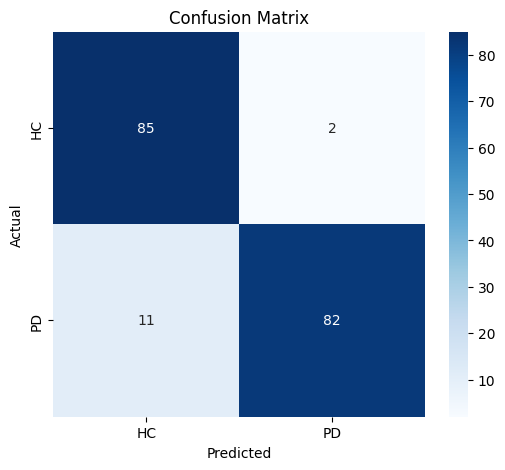

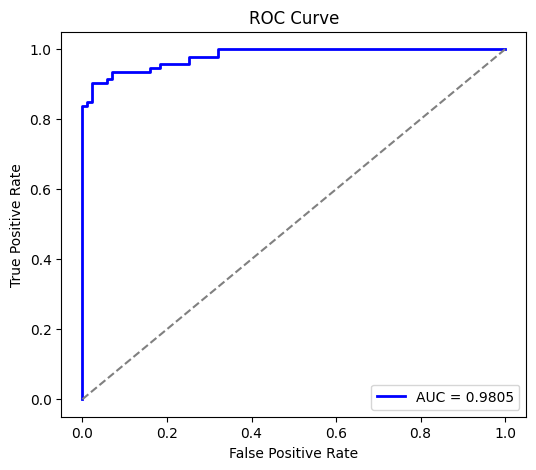

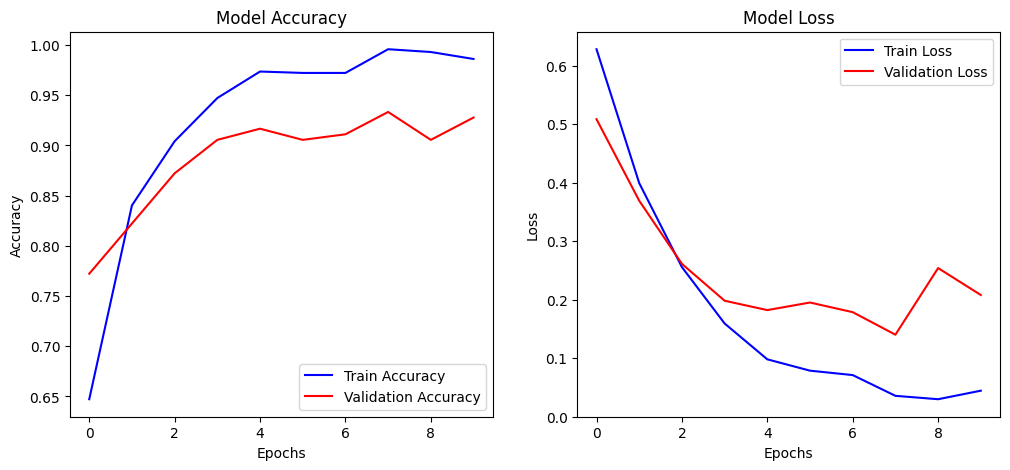

Final Validation Accuracy: 92.78%
🔥 CNN Model Performance:
              precision    recall  f1-score   support

          HC       0.89      0.98      0.93        87
          PD       0.98      0.88      0.93        93

    accuracy                           0.93       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.93      0.93      0.93       180

AUC-ROC Score: 0.9805


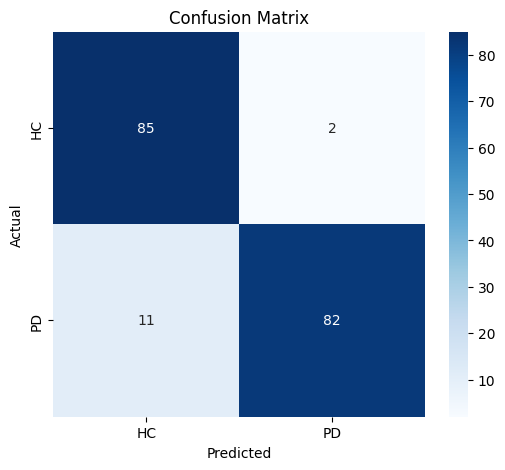

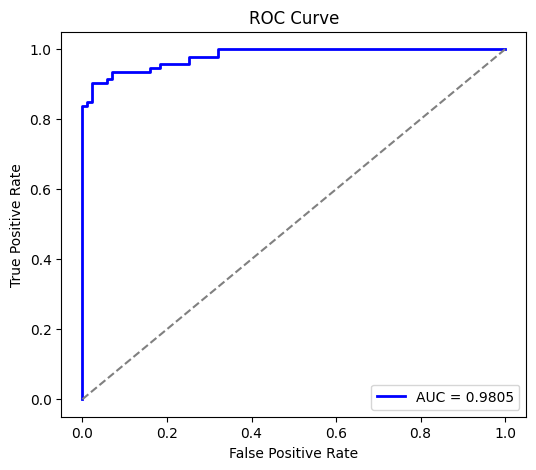

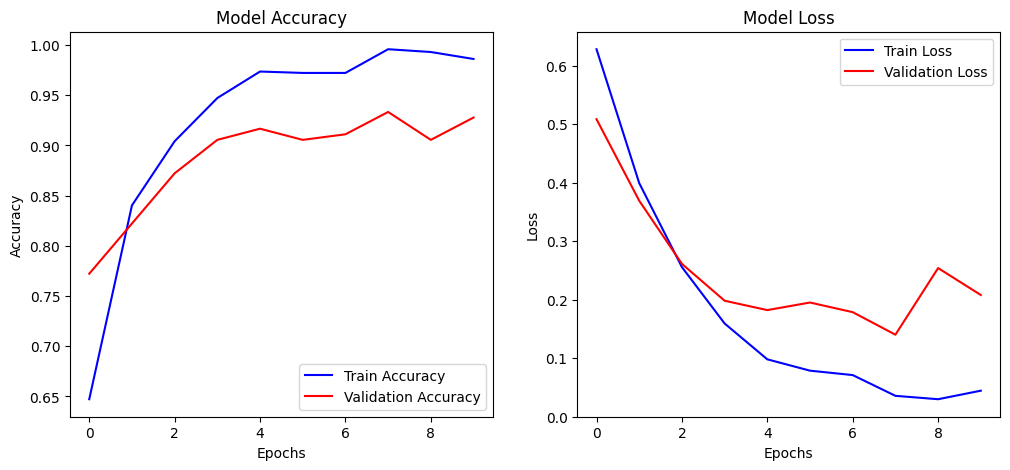

In [6]:

# ✅ Load the Trained Model (If Not Already in Memory)
model.eval()
val_loss, val_correct = 0.0, 0

# ✅ Evaluate on Test Data
y_true = []
y_pred = []
y_pred_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get probabilities for Class 1 (PD)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        y_pred_probs.extend(probs)

print(f"Final Validation Accuracy: {history['val_acc'][-1] * 100:.2f}%")
# ✅ Print Classification Report
print("🔥 CNN Model Performance:")
print(classification_report(y_true, y_pred, target_names=["HC", "PD"]))

# ✅ Compute AUC-ROC Score
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# ✅ Load Training History
history = np.load("/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/training_history.npy", allow_pickle=True).item()

# ✅ Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

# 🔹 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy", color="blue")
plt.plot(history["val_acc"], label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# 🔹 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss", color="blue")
plt.plot(history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()


Evaluating on New Test Set

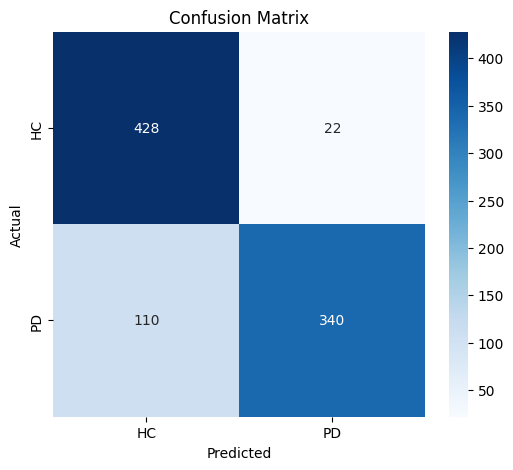

              precision    recall  f1-score   support

          HC       0.80      0.95      0.87       450
          PD       0.94      0.76      0.84       450

    accuracy                           0.85       900
   macro avg       0.87      0.85      0.85       900
weighted avg       0.87      0.85      0.85       900



In [7]:

# 🔹 Load the model (Ensure it's already trained)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # Set to evaluation mode

# 🔹 Load new dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Same as training
])

new_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram1", transform=transform)
new_loader = torch.utils.data.DataLoader(new_dataset, batch_size=16, shuffle=False)

# 🔹 Evaluate and Collect Predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in new_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 🔹 Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = new_dataset.classes  # Get class names from dataset

# 🔹 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 🔹 Print Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))


# GRAD-CAM

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
import torchvision.models as models

Load model

In [ ]:

# Load the saved model checkpoint
model_path = '/content/drive/MyDrive/PD_DL_MainProject_2023-24/Haleem/Audio Feature Ensemble/DL evaluation metrics/MDVR-KCL/ResNet 50/resnet_model.pth'
checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Load ResNet18 architecture
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # For binary classification (HC vs PD)
model.fc = nn.Sequential(
    nn.Dropout(0.4),  # Dropout 0.4
    nn.Linear(num_features , 2)
)
# Load the saved model state_dict
model.load_state_dict(checkpoint)

# Set model to evaluation mode
model.eval()


In [2]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)

        # Choose the class index with highest probability if not specified
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        output[0, class_idx].backward()

        # Compute Grad-CAM
        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()

        weights = np.mean(gradients, axis=(2, 3))  # Global average pooling
        cam = np.zeros(activations.shape[2:], dtype=np.float32)

        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)  # ReLU to keep only positive activations
        cam = cv2.resize(cam, (224, 224))  # Resize to input size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)  # Normalize to [0,1]
        return cam


In [7]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    img = Image.open(image_path).convert('RGB')  # Convert to RGB
    img_tensor = transform(img).unsqueeze(0)    # Add batch dimension
    return img_tensor


In [5]:
def visualize_gradcam(model, image_path, target_layer):
    # Load and preprocess spectrogram
    input_tensor = preprocess_image(image_path)

    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)

    # Generate Grad-CAM heatmap
    cam = gradcam.generate_cam(input_tensor)

    # Load original image for overlay
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, (224, 224))

    # Convert heatmap to color
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay Grad-CAM on original spectrogram
    overlayed_image = (0.5 * heatmap + 0.5 * cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)).astype(np.uint8)

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Spectrogram")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title("Overlayed Grad-CAM")

    plt.show()


In [ ]:
print(model)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


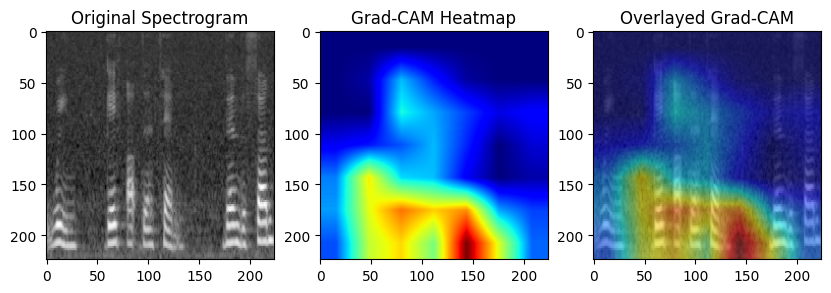

In [13]:
# Choose a ResNet layer for Grad-CAM (last convolutional layer)
target_layer = model.layer4[2].conv3  # Last conv layer

# Provide a sample spectrogram image path
spectrogram_image_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Data Set/KCL_spectrogram/HC/HC_ID00_hc_0_0_0_clip15_aug1.png"
# Run Grad-CAM visualization
visualize_gradcam(model, spectrogram_image_path, target_layer)


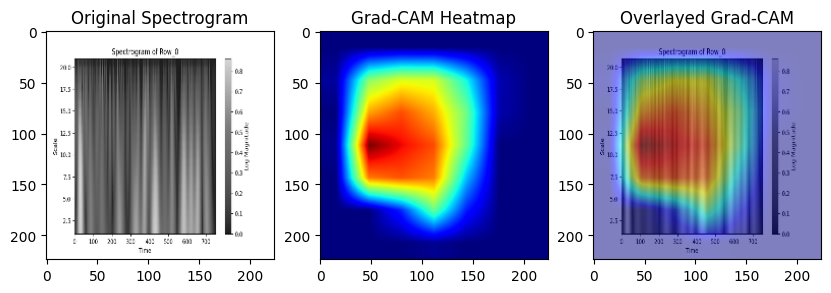

In [ ]:
# Choose a ResNet layer for Grad-CAM (last convolutional layer)
target_layer = model.resnet50.layer4[2].conv3  # Last conv layer

# Provide a sample spectrogram image path
spectrogram_image_path = "/content/drive/MyDrive/PD_DL_MainProject_2023-24/Anantha Padmanabhan/Dataset-Audio/Sakar pd speech time series converted/Normalised/spectrogram/HC/Row_0_spectrogram.png"

# Run Grad-CAM visualization
visualize_gradcam(model, spectrogram_image_path, target_layer)
